# [Getting started with PyMC3](https://docs.pymc.io/notebooks/getting_started.html)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm

%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
gg.theme_set(gg.theme_minimal)

## A Motivating Example: Linear Regression

$$
Y \sim \mathcal{N}(\mu, \sigma^2) \\
\mu = \alpha + \beta_1 X_1 + \beta_2 X_2 \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta_1 \sim \mathcal{N}(0, 10) \\
\beta_2 \sim \mathcal{N}(0, 10) \\
\sigma \sim |\mathcal{N}(0, 1)|
$$

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_wrap.py:215: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


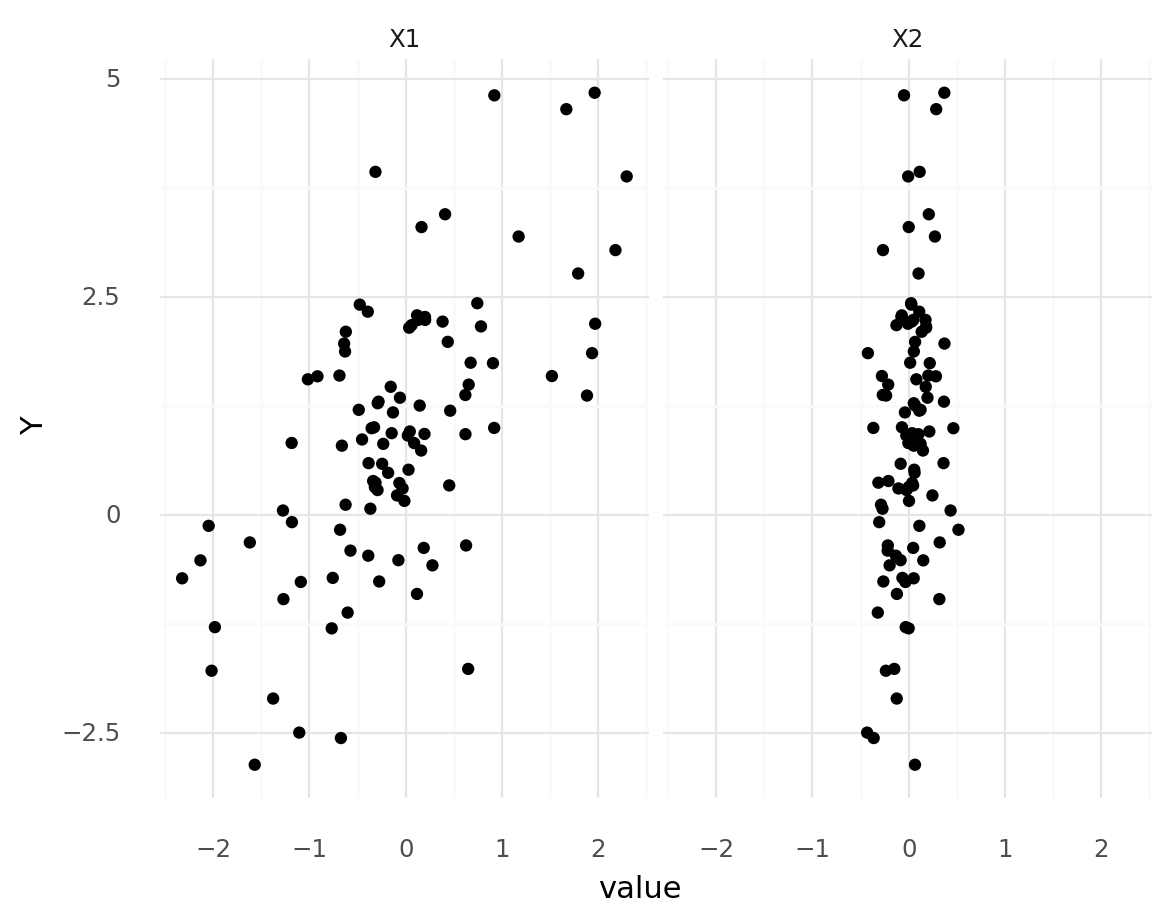

<ggplot: (283518341)>

In [2]:
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0] * X1 + beta[1] * X2 + (np.random.randn(size) * sigma)

d = pd.DataFrame({"X1": X1, "X2": X2, "Y": Y}).melt(id_vars="Y")

(
    gg.ggplot(d, gg.aes("value", "Y"))
    + gg.facet_wrap("variable", nrow=1, scales="fixed")
    + gg.geom_point()
)

In [3]:
with pm.Model() as basic_model:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=2)
    sigma = pm.HalfNormal("sigma", 1)

    mu = alpha + beta[0] * X1 + beta[1] * X2

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace = pm.sample(5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 31 seconds.


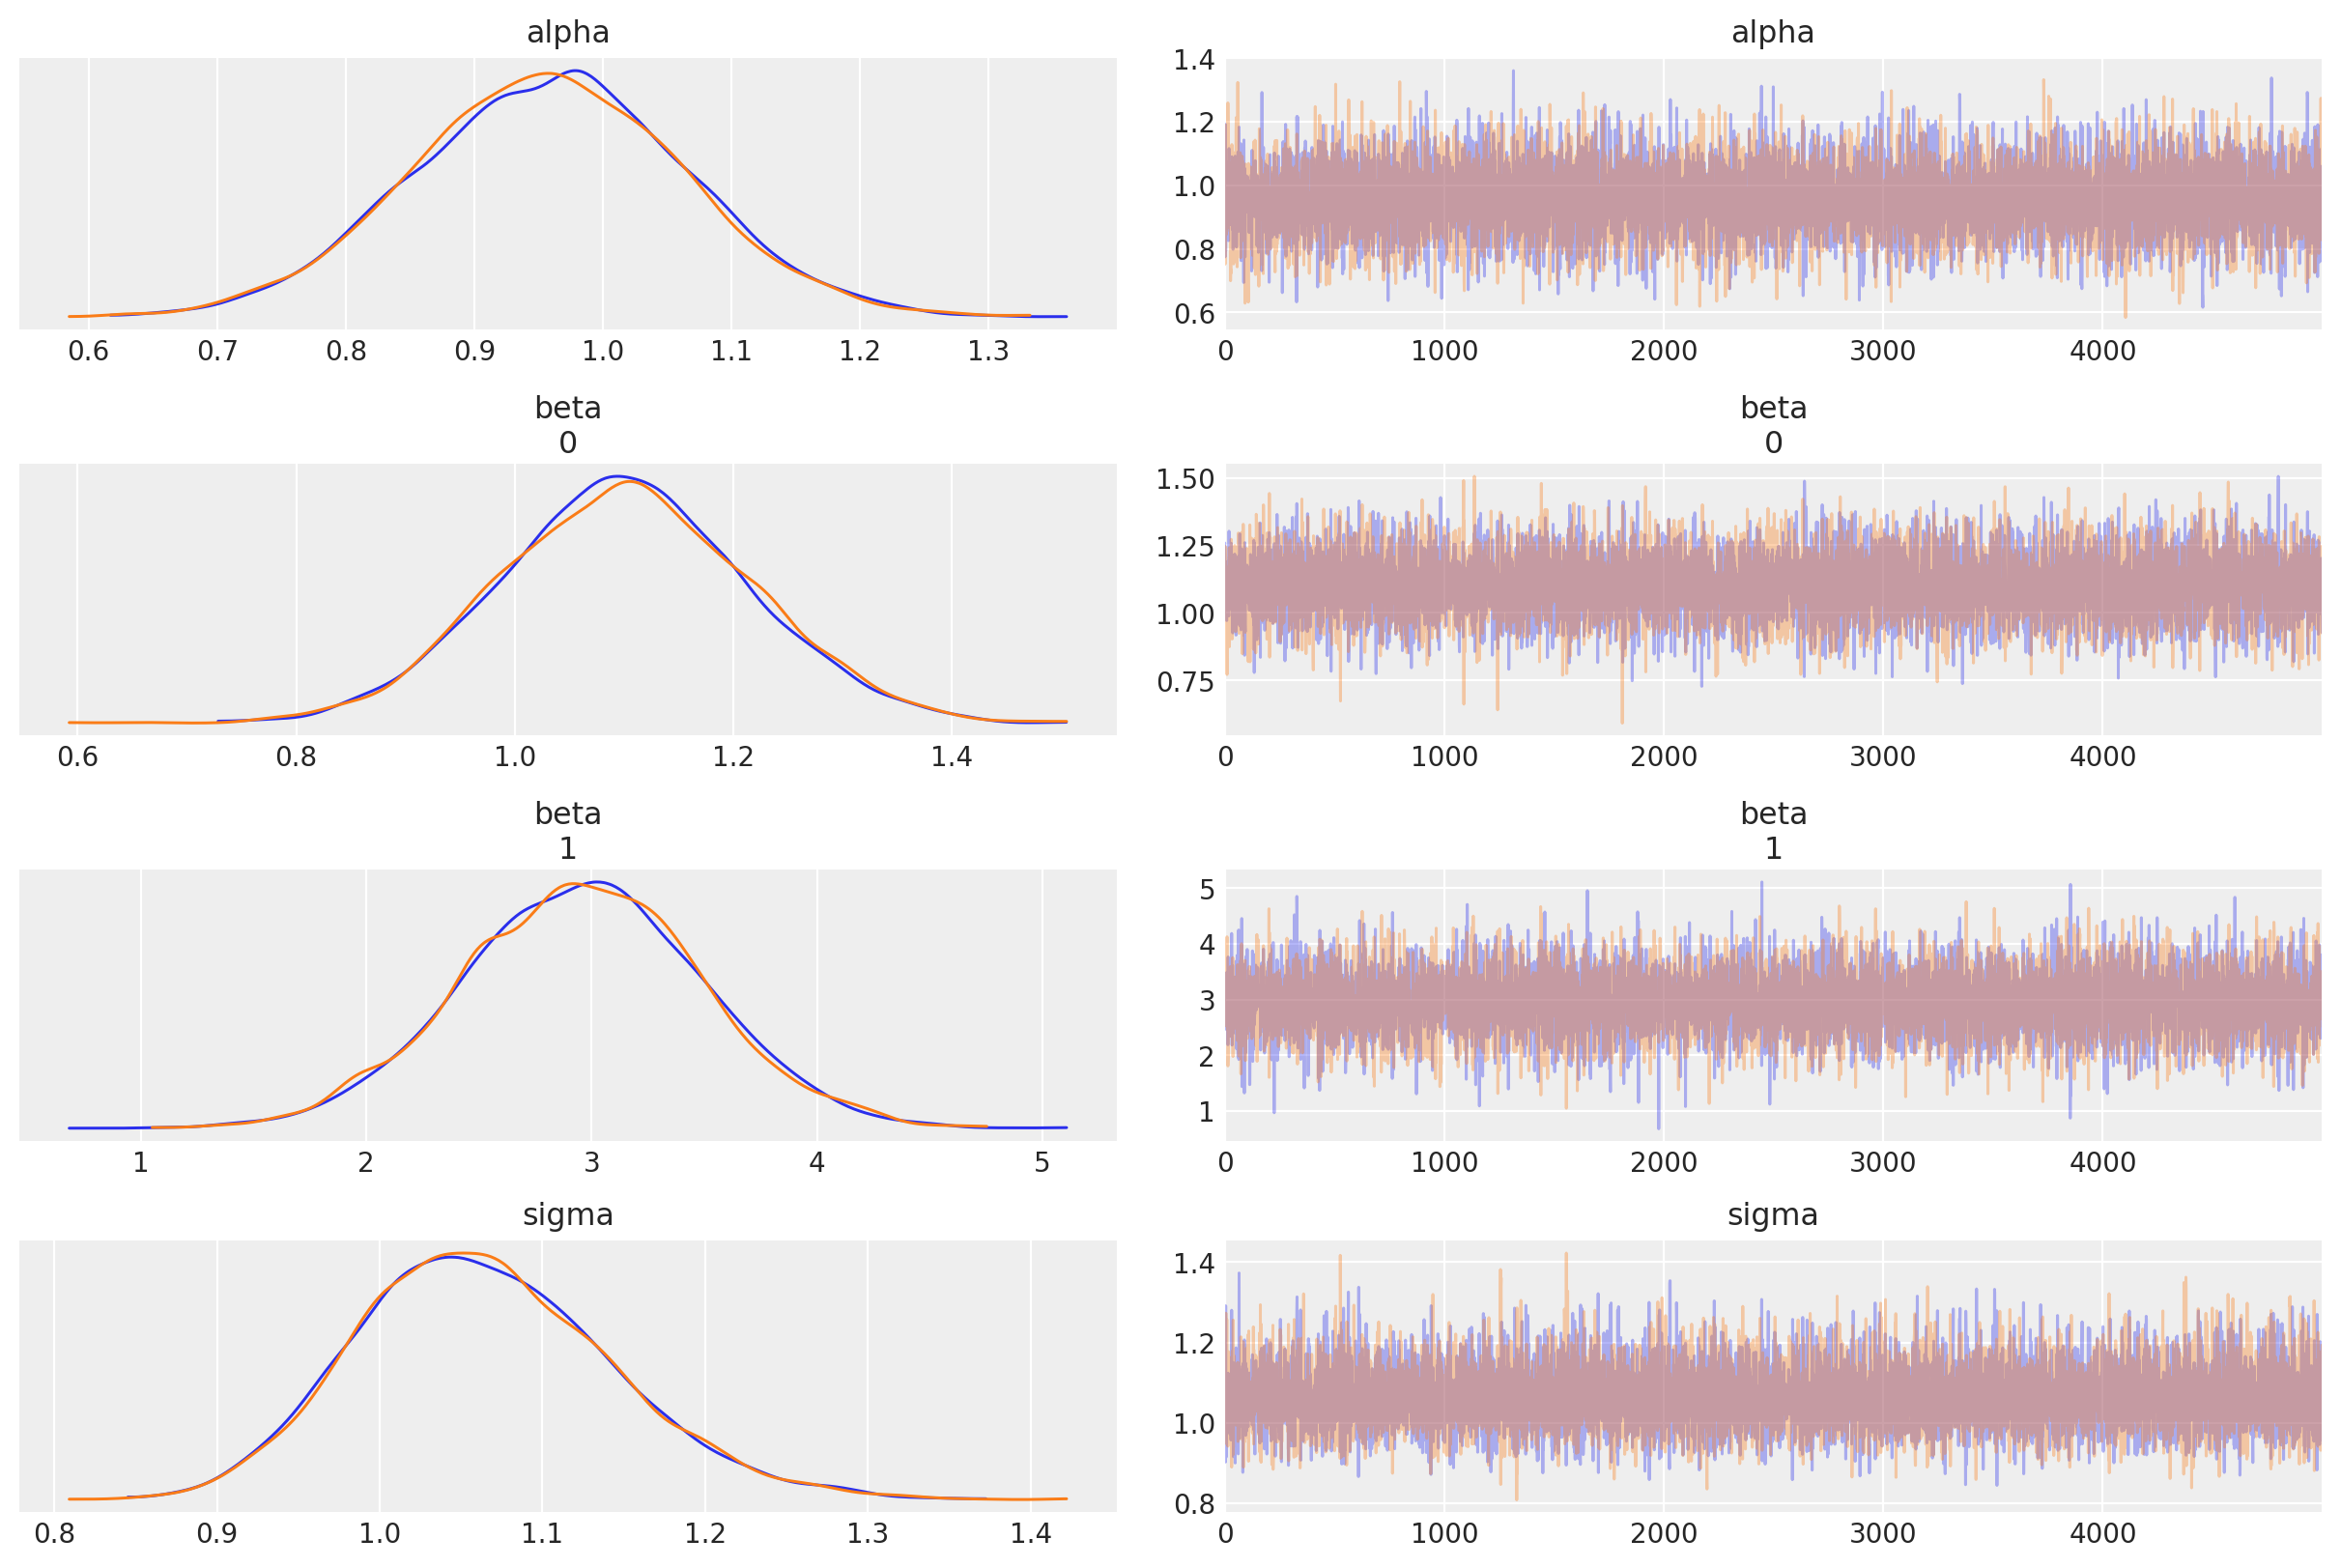

In [4]:
az.plot_trace(trace, compact=False)
plt.show()

In [5]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.958,0.107,0.759,1.162,0.001,0.001,15834.0,15524.0,15831.0,8046.0,1.0
beta[0],1.101,0.114,0.893,1.319,0.001,0.001,13106.0,12921.0,13088.0,7863.0,1.0
beta[1],2.952,0.540,1.891,3.920,0.004,0.003,15443.0,14832.0,15497.0,7830.0,1.0
sigma,1.064,0.079,0.917,1.209,0.001,0.001,12512.0,12036.0,13024.0,7047.0,1.0


## Case Study 1: Stochastic volatility

A case study on stock market volatility.
The distribution of market returns is non-normal, making smapling more difficult.

Asset prices have *time-varying volatility*, variance of day-over-day returns.
Sometimes, returns are highly volatile and other times prices are more stable.
This *stochasitc volatility model* addresses this with a latent volatility variable than changes over time.

$$
\log(r_i) \sim t(\nu, 0, \exp(-2s_i)) \\
s_i \sim \mathcal{N}(s_{i-1}, \sigma^2) \\
\nu \sim \exp(0.1) \\
\sigma \sim \exp(50)
$$

Here, $R$ is the faily return series modeled with a Student's *t*-distribution with an unknown degrees of freedom parameter $\nu$ and a scale parameter determined by a latent process $s$.
An individual $s_i$ is an individual daily log volatilities in the latent log volatility process.

Use data from S&P 500 indexsince the 2008 crisis.

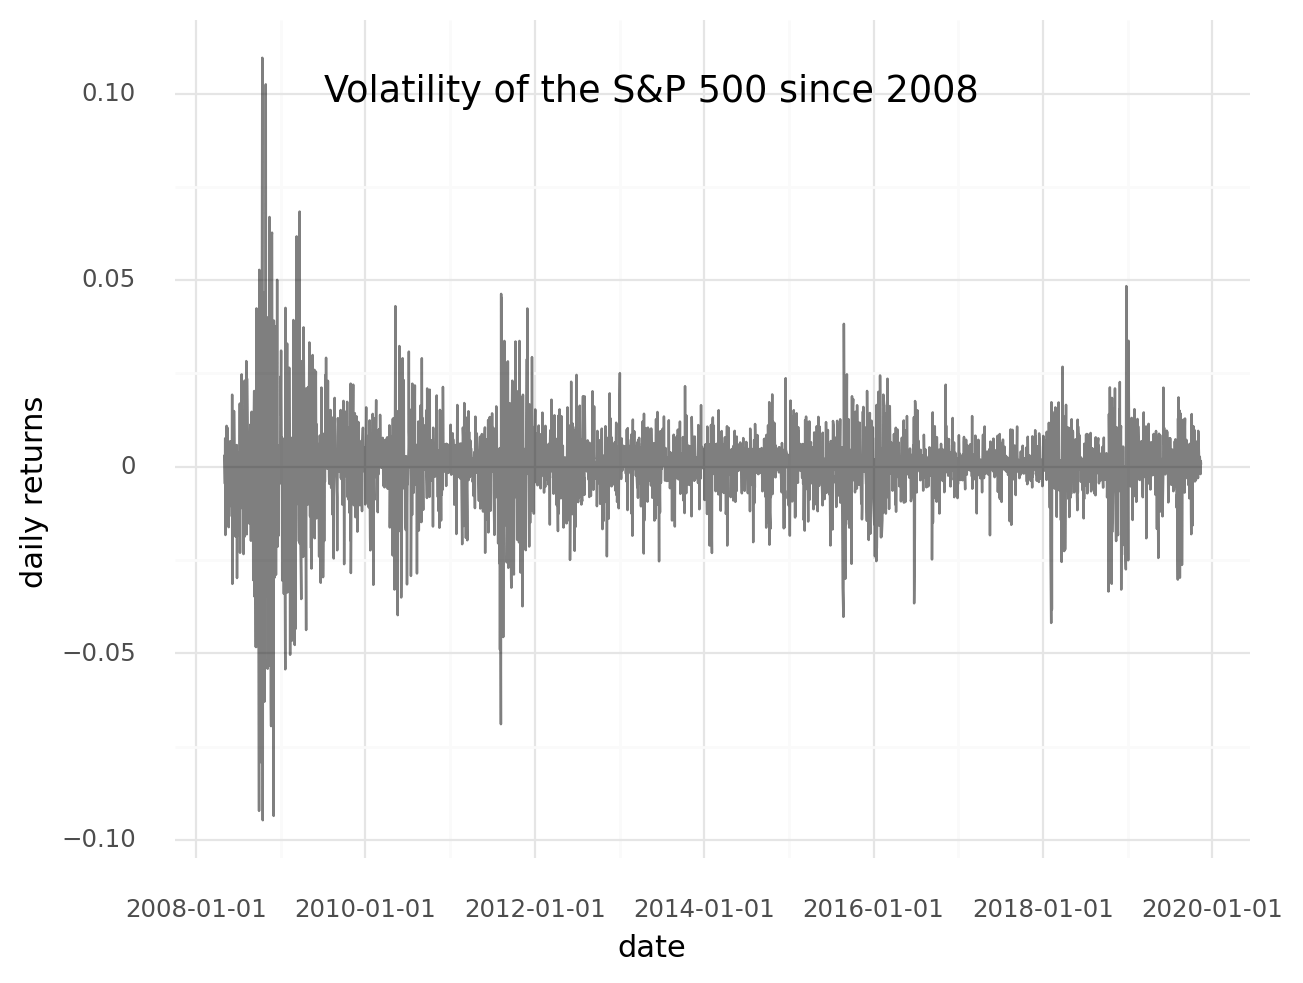

<ggplot: (355848084)>

In [6]:
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
).reset_index(drop=False)

(
    gg.ggplot(returns, gg.aes(x="Date", y="change"))
    + gg.geom_line(alpha=0.5, size=0.5)
    + gg.labs(x="date", y="daily returns", title="Volatility of the S&P 500 since 2008")
)

Use a `GaussianRandomWalk` as the prior for the latent volatilities.
It is a vector-valued distribution where the values of the vector form a random normal walk of length $n$, specified by the `shape` parameter.

We can provide initial values for any distribution, known as *test values*, using the `testval` parameter.
This can be useful if some values are illegal and we want to ensure a legal value is selected.

In [7]:
with pm.Model() as sp500_model:
    change_returns = pm.Data(
        "returns", returns["change"], dims="date", export_index_as_coords=True
    )

    nu = pm.Exponential("nu", 1.0 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")

    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT(
        "r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date"
    )

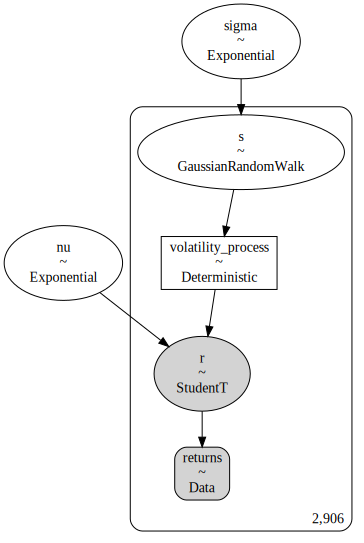

In [8]:
pm.model_to_graphviz(sp500_model)

In [9]:
sp500_model.RV_dims

{'returns': ('date',),
 's': ('date',),
 'volatility_process': ('date',),
 'r': ('date',)}

In [10]:
sp500_model.coords

{'date': RangeIndex(start=0, stop=2906, step=1)}

In [11]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 627 seconds.


0, dim: date, 2906 =? 2906


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


0, dim: date, 2906 =? 2906
0, dim: date, 2906 =? 2906


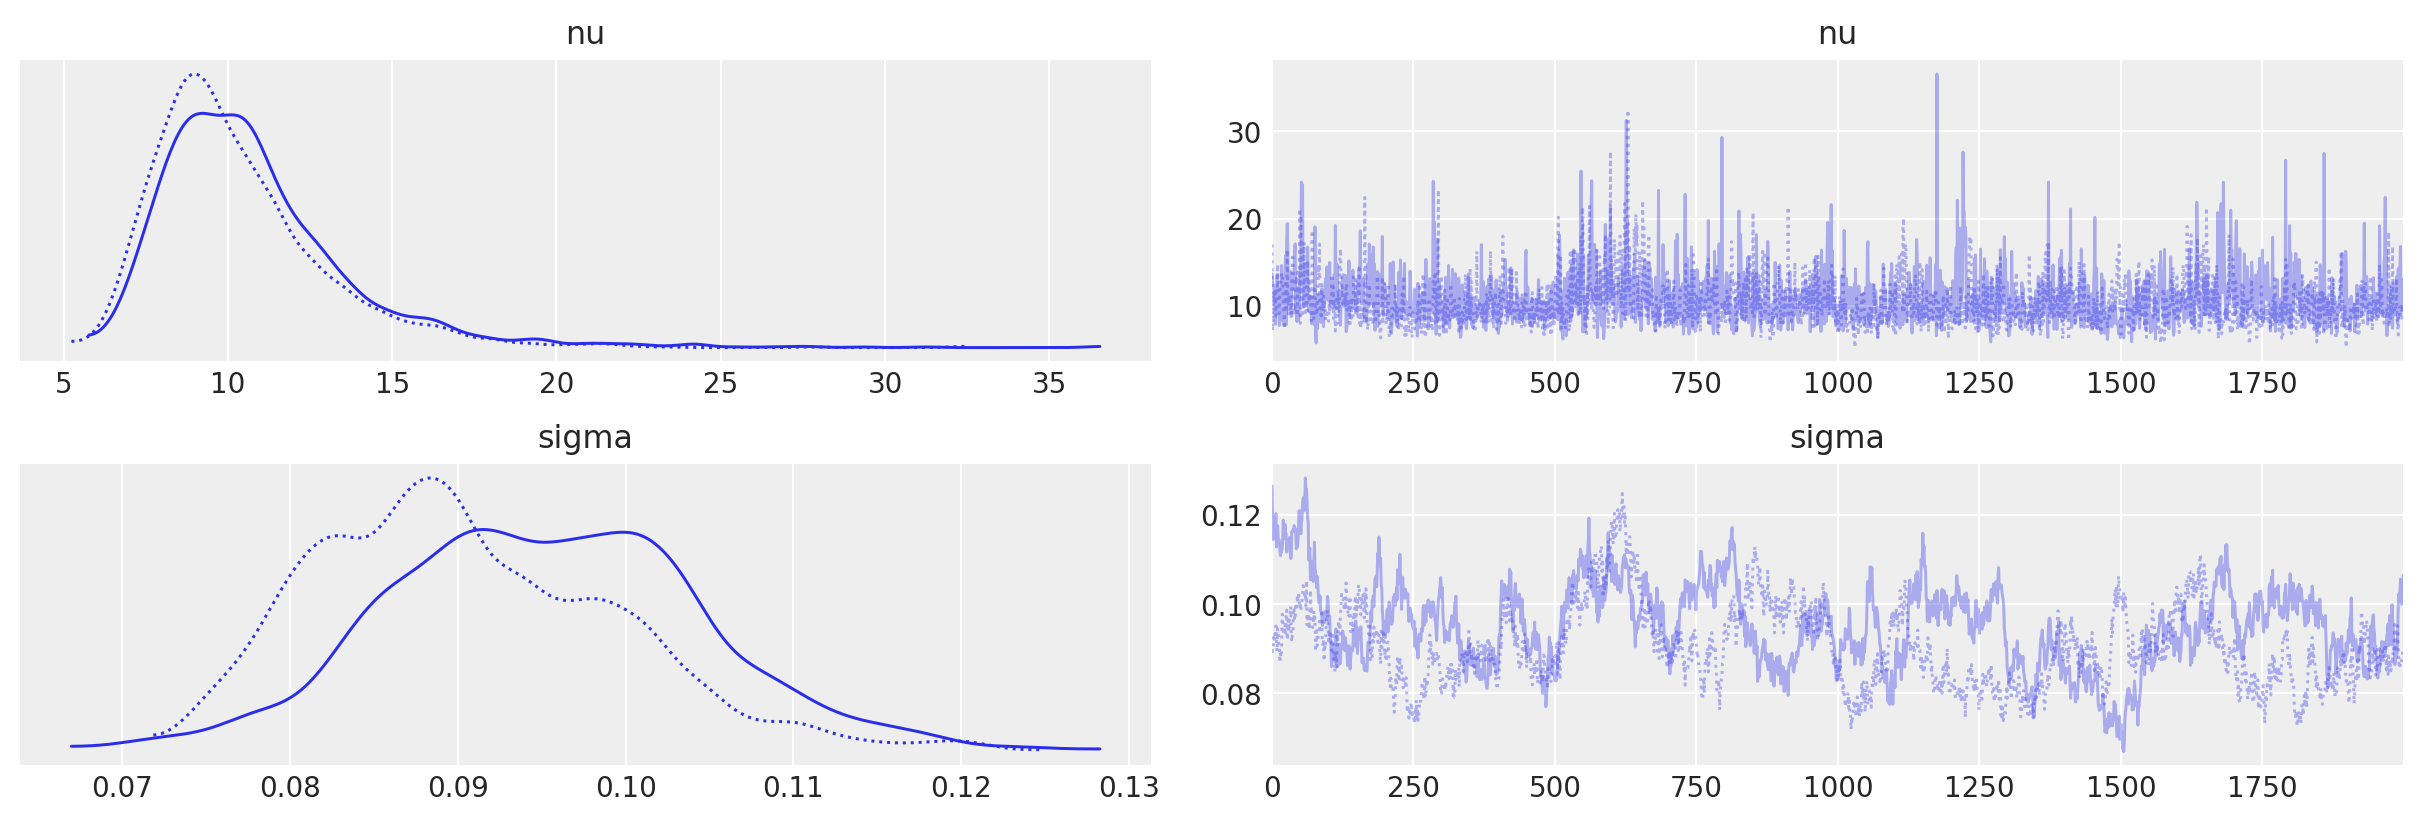

In [12]:
az.plot_trace(trace, combined=False, var_names=["nu", "sigma"])
plt.show()

---

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 21 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

plotnine  : 0.7.1
pymc3     : 3.9.3
pandas    : 1.2.0
arviz     : 0.11.0
matplotlib: 3.3.3
numpy     : 1.19.5

Watermark: 2.1.0

